In [1]:
!git clone https://github.com/timeseriesAI/timeseriesAI.git

Cloning into 'timeseriesAI'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 38 (delta 4), reused 38 (delta 4), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [2]:
%cd timeseriesAI

/content/timeseriesAI


In [8]:
!pip install tslearn

     |████████████████████████████████| 522kB 2.9MB/s 
  Created wheel for tslearn: filename=tslearn-0.2.2-cp36-cp36m-linux_x86_64.whl size=801371 sha256=0df8745bba6f2259b56fb989d3b7c27127f85d7f8a80735812376a393bdfc7fd
  Stored in directory: /root/.cache/pip/wheels/e5/7f/ba/cf984e0e778fae5640d7f4173ec75ce460ad6bbd4eafdae458
Successfully built tslearn


In [10]:
!pip install pyts

     |████████████████████████████████| 2.5MB 2.8MB/s 


In [11]:
import fastai, os
from fastai_timeseries import *
from torchtimeseries.models import *
path = Path(os.getcwd())
print(path)
print('fastai :', fastai.__version__)
print('torch  :', torch.__version__)
print('device :', device)

/content/timeseriesAI
fastai : 1.0.57
torch  : 1.2.0
device : cuda


In [0]:
dsid = 'ChlorineConcentration'

In [13]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)

Dataset: ChlorineConcentration
Successfully extracted file /tmp/tmpu9sdzqha/ChlorineConcentration.zip to path data/UCR/ChlorineConcentration
Successfully extracted dataset
X_train: (467, 1, 166)
y_train: (467,)
X_valid: (3840, 1, 166)
y_valid: (3840,)


In [0]:
bs = 64                            # ✳️
seed = 1234                        # ✳️
scale_type = 'standardize'         # ✳️ 'standardize', 'normalize'
scale_subtype = 'per_channel'      # ✳️ 'all_samples', 'per_channel', 'per_sample'
scale_range = (-1, 1)              # ✳️ for normalization only: usually left to (-1, 1)

In [0]:
db = (ItemLists('.', TimeSeriesList(X_train), TimeSeriesList(X_valid))
      .label_from_lists(y_train, y_valid)
      .databunch(bs=min(bs, len(X_train)), val_bs=min(len(X_valid), bs * 2), num_workers=cpus, device=device)
      .scale(scale_type=scale_type, scale_subtype=scale_subtype, scale_range=scale_range)
     )

In [0]:
from torchtimeseries.models import *
# Select one arch from these state-of-the-art time series/ 1D models:
# ResCNN, FCN, InceptionTime, ResNet
arch = MishInceptionTime                     # ✳️   
arch_kwargs = dict()                     # ✳️ 
opt_func=Ranger                          # ✳️ a state-of-the-art optimizer
loss_func = LabelSmoothingCrossEntropy() # ✳️

In [0]:
import torch
import torch.nn as nn

__all__ = ['InceptionTime']

def noop(x):
    return x

def shortcut(c_in, c_out):
    return nn.Sequential(*[nn.Conv1d(c_in, c_out, kernel_size=1), 
                           nn.BatchNorm1d(c_out)])
    
class Inception(nn.Module):
    def __init__(self, c_in, bottleneck=32, ks=40, nb_filters=32):

        super().__init__()
        self.bottleneck = nn.Conv1d(c_in, bottleneck, 1) if bottleneck and c_in > 1 else noop
        mts_feat = bottleneck or c_in
        conv_layers = []
        kss = [ks // (2**i) for i in range(3)]
        # ensure odd kss until nn.Conv1d with padding='same' is available in pytorch 1.3
        kss = [ksi if ksi % 2 != 0 else ksi - 1 for ksi in kss]  
        for i in range(len(kss)):
            conv_layers.append(
                nn.Conv1d(mts_feat, nb_filters, kernel_size=kss[i], padding=kss[i] // 2))
        self.conv_layers = nn.ModuleList(conv_layers)
        self.maxpool = nn.MaxPool1d(3, stride=1, padding=1)
        self.conv = nn.Conv1d(c_in, nb_filters, kernel_size=1)
        self.bn = nn.BatchNorm1d(nb_filters * 4)
        self.act = Mish()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        for i in range(3):
            out_ = self.conv_layers[i](x)
            if i == 0: out = out_
            else: out = torch.cat((out, out_), 1)
        mp = self.conv(self.maxpool(input_tensor))
        inc_out = torch.cat((out, mp), 1)
        return self.act(self.bn(inc_out))


class InceptionBlock(nn.Module):
    def __init__(self,c_in,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):

        super().__init__()

        self.residual = residual
        self.depth = depth

        #inception & residual layers
        inc_mods = []
        res_layers = []
        res = 0
        for d in range(depth):
            inc_mods.append(
                Inception(c_in if d == 0 else nb_filters * 4, bottleneck=bottleneck if d > 0 else 0,ks=ks,
                          nb_filters=nb_filters))
            if self.residual and d % 3 == 2:
                res_layers.append(shortcut(c_in if res == 0 else nb_filters * 4, nb_filters * 4))
                res += 1
            else: res_layer = res_layers.append(None)
        self.inc_mods = nn.ModuleList(inc_mods)
        self.res_layers = nn.ModuleList(res_layers)
        self.act = Mish()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inc_mods[d](x)
            if self.residual and d % 3 == 2:
                res = self.res_layers[d](res)
                x += res
                res = x
                x = self.act(x)
        return x
    
class MishInceptionTime(nn.Module):
    def __init__(self,c_in,c_out,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):
        super().__init__()
        self.block = InceptionBlock(c_in,bottleneck=bottleneck,ks=ks,nb_filters=nb_filters,
                                    residual=residual,depth=depth)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nb_filters * 4, c_out)

    def forward(self, x):
        x = self.block(x)
        x = self.gap(x).squeeze(-1)
        x = self.fc(x)
        return x

In [0]:
import torch
import torch.nn.functional as F

def mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    See additional documentation for mish class.
    '''
    return input * torch.tanh(F.softplus(input))

In [0]:
class Mish(nn.Module):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        >>> m = Mish()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return mish(input)

In [22]:
model = arch(db.features, db.c, **arch_kwargs).to(device)
learn = Learner(db, model, opt_func=opt_func, loss_func=loss_func)
learn.save('stage_0')
print(learn.model)
print(learn.summary())

MishInceptionTime(
  (block): InceptionBlock(
    (inc_mods): ModuleList(
      (0): Inception(
        (conv_layers): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        )
        (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Mish()
      )
      (1): Inception(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (conv_layers): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [23]:
learn.load('stage_0')

Learner(data=TSDataBunch;

Train: LabelList (467 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166)
y: CategoryList
1,3,1,3,2
Path: .;

Valid: LabelList (3840 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166)
y: CategoryList
2,2,1,3,2
Path: .;

Test: None, model=MishInceptionTime(
  (block): InceptionBlock(
    (inc_mods): ModuleList(
      (0): Inception(
        (conv_layers): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        )
        (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv): Conv1d(1, 32

In [0]:
epochs = 100         # ✳️ 
max_lr = 1e-2        # ✳️ 
warmup = False       # ✳️
pct_start = .7       # ✳️
metrics = [accuracy] # ✳️
wd = 1e-2

epoch,train_loss,valid_loss,accuracy,time
0,1.076742,1.071123,0.532552,00:01
1,1.034203,1.058715,0.532552,00:01
2,1.017670,1.034151,0.537240,00:01
3,1.006715,1.014012,0.550000,00:01
4,0.997490,1.009708,0.555729,00:01
5,0.988209,1.268923,0.467708,00:01
6,0.981744,1.130313,0.558073,00:01
7,0.976610,1.236048,0.456510,00:01
8,0.968480,1.241492,0.401042,00:01
9,0.959533,1.093716,0.478906,00:01


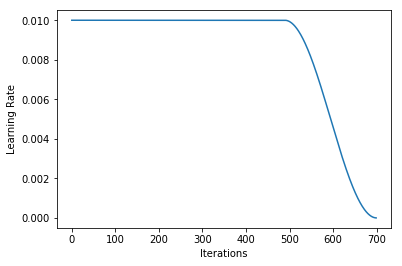

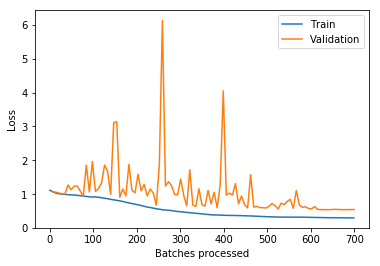

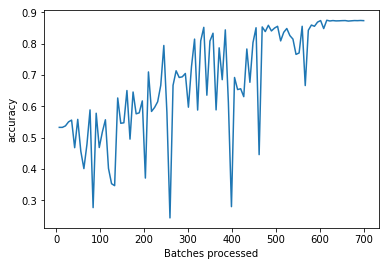

In [25]:
learn.metrics = metrics
learn.load('stage_0')
learn.fit_one_cycle(epochs, max_lr=4e-3, pct_start=pct_start, moms=(.95, .85) if warmup else (.95, .95),
                    div_factor=25.0 if warmup else 1., wd=wd)
learn.save('stage_1')
learn.recorder.plot_lr()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,0.883655,1.112986,0.532552,00:01
1,0.652592,1.124610,0.532552,00:01
2,0.562551,1.026654,0.561719,00:01
3,0.523359,0.986443,0.637760,00:01
4,0.515290,1.502807,0.563542,00:01
5,0.490770,1.012225,0.595573,00:01
6,0.474524,1.112630,0.717188,00:01
7,0.457546,0.782130,0.778385,00:01
8,0.445443,2.505208,0.548437,00:01
9,0.434259,0.761033,0.786719,00:01


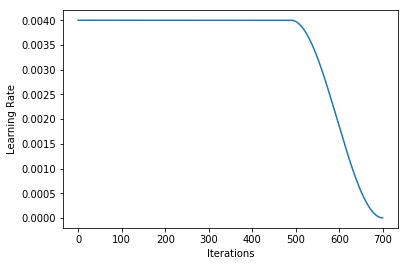

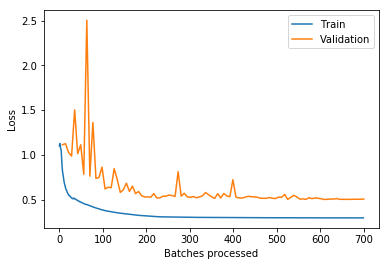

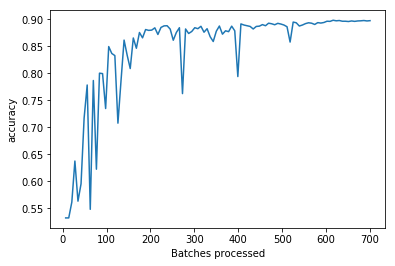

In [26]:
learn.metrics = metrics
learn.load('stage_0')
learn.fit_one_cycle(epochs, max_lr=4e-3, pct_start=pct_start, moms=(.95, .85) if warmup else (.95, .95),
                    div_factor=25.0 if warmup else 1., wd=wd)
learn.save('stage_1')
learn.recorder.plot_lr()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()